# Visualize Data

We will plot the data over the entire 39000 tick history to see if we can notice anything.
1. Assets 1,2,3 seem to be relativley correlated and assets 4,5,6 seem to be even more correlated
2. Assets 1,2,3 are much less volatile than 4,5,6

30 ticks per day


39000


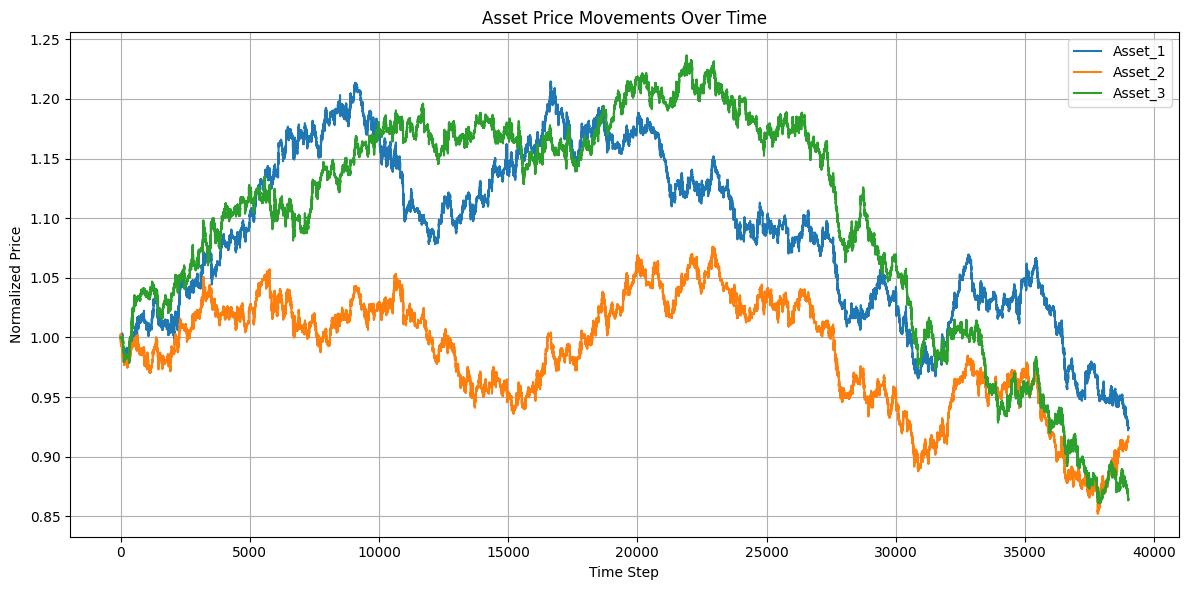

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Case2.csv')
print(len(data))
plt.figure(figsize=(12, 6))
for col in data.columns[:3]:
    plt.plot(range(len(data)), data[col], label=col)

plt.title("Asset Price Movements Over Time")
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Case2.csv')
returns = data.pct_change().dropna()

volatility = returns.std()
print("Volatility (Standard Deviation of Returns):")
print(volatility)



Volatility (Standard Deviation of Returns):
Asset_1    0.001253
Asset_2    0.001345
Asset_3    0.001261
Asset_4    0.003368
Asset_5    0.003371
Asset_6    0.003242
dtype: float64


# Visualize Correlation
Assets 1,2,3 are relativley correlated while it seems like the high volatility of assets 4,5,6 cause them to not be statistically correlated


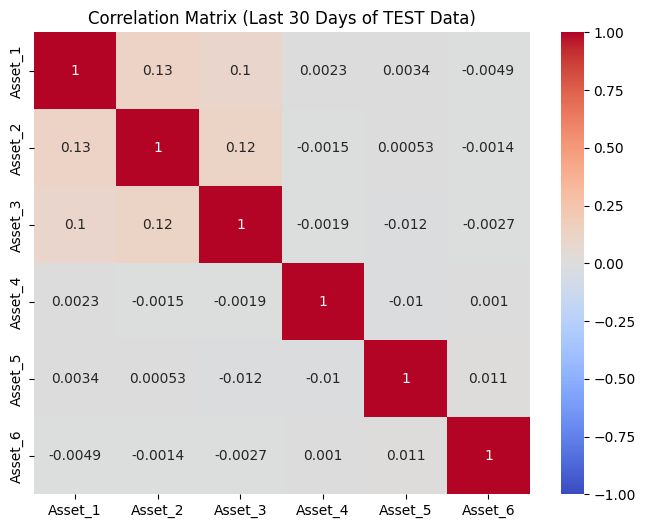

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate daily returns from the full TEST set
returns = data.pct_change().dropna()

# Use the last 30 days of returns
recent_returns = returns.iloc[:]

# Compute the correlation matrix
corr_matrix = recent_returns.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Last 30 Days of TEST Data)")
plt.show()


# Strategy V2
Tuning hyperparameters and accounting for asset volatility

-0.026520657599531476
Capital shape: 3900 | Test shape: 3900


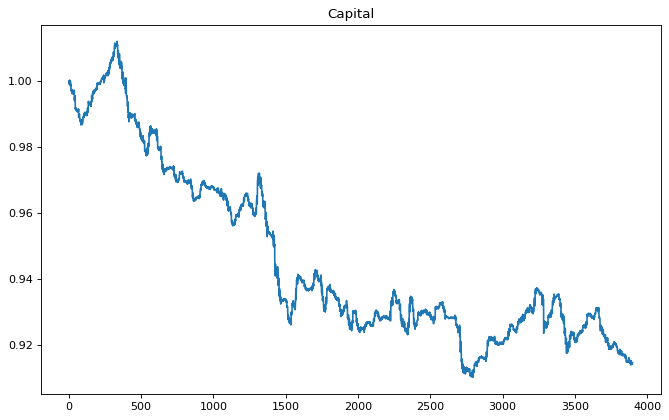

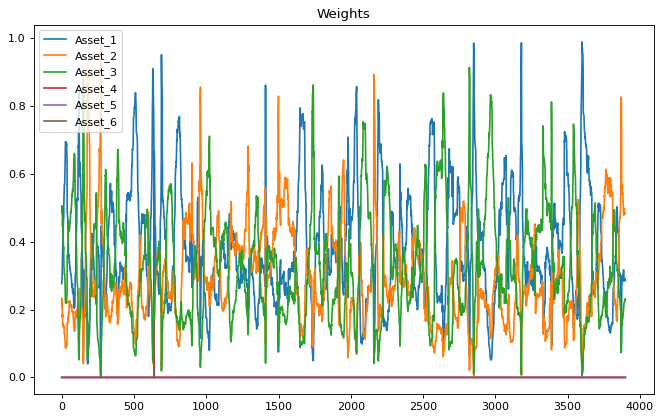

[1.         0.99955378 0.99916871 ... 0.91423939 0.91453118 0.91471746]


In [32]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.optimize import minimize


data = pd.read_csv('Case2.csv')

'''
We recommend that you change your train and test split
'''

TRAIN, TEST = train_test_split(data, test_size = 0.1, shuffle = False)


class Allocator():
    def __init__(self, train_data):
        '''
        Store raw prices and calculate running returns separately
        '''
        self.running_price_paths = train_data.copy()
        #new var to test returns
        self.daily_returns = train_data.pct_change().dropna().copy()
        self.train_data = train_data.copy()

    def allocate_portfolio(self, asset_prices):
        new_row = pd.DataFrame([asset_prices], columns=self.train_data.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

        # Update returns
        if len(self.running_price_paths) >= 2:
            last_return = self.running_price_paths.iloc[-1] / self.running_price_paths.iloc[-2] - 1
            self.daily_returns = pd.concat(
                [self.daily_returns, pd.DataFrame([last_return], columns=self.train_data.columns)],
                ignore_index=True
            )

        if len(self.daily_returns) < 30:
            return np.full(6, 1/6)

        # split assets into two windows since they have different volatilities
        assets_first3 = self.daily_returns.iloc[:, :3]
        assets_last3 = self.daily_returns.iloc[:, 3:]

        # asset 1,2,3 30
        recent_returns_first3 = assets_first3.iloc[-200:]
        mu_first3 = recent_returns_first3.mean().values
        cov_first3 = recent_returns_first3.cov().values

        # asset 4,5,6
        recent_returns_last3 = assets_last3.iloc[-5:]
        mu_last3 = recent_returns_last3.mean().values
        cov_last3 = recent_returns_last3.cov().values

        # sharpe def
        def sharpe(w, mu, cov):
            ret = np.dot(w, mu)
            vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            return ret / vol if vol > 0 else 1e6

        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(-1, 1)] * 3

        # first 3 asset markowitz
        w0_first3 = np.full(3, 1/3)
        result_first3 = minimize(
            lambda w: -sharpe(w, mu_first3, cov_first3),
            w0_first3,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 100, 'ftol': 1e-6})

        # last 3 asset markowitz
        w0_last3 = np.full(3, 1/3)
        result_last3 = minimize(
            lambda w: -sharpe(w, mu_last3, cov_last3),
            w0_last3,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 100, 'ftol': 1e-6})

        if result_first3.success and result_last3.success:
            weights_first3 = result_first3.x
            weights_last3 = [0,0,0]#result_last3.x
            combined_weights = np.concatenate([weights_first3, weights_last3])
            combined_weights = combined_weights / np.sum(np.abs(combined_weights))
            return combined_weights
        else:
            #if optimization fails
            return np.full(6, 1/6)

def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0

    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
print(sharpe)
print("Capital shape:", len(capital), "| Test shape:", len(TEST))

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()
print(capital)

In [17]:
import pandas as pd
import numpy as np

data = pd.read_csv('Case2.csv')

def estimate_optimal_window(prices, threshold=0.0):
    windows = {}
    for asset in prices.columns[:3]:  # For Assets 1, 2, 3
        days_to_move = []
        series = prices[asset].values
        for i in range(len(series) - 1):
            start_price = series[i]
            for j in range(i + 1, len(series)):
                change = abs(series[j] / start_price - 1)
                if change >= threshold:
                    days_to_move.append(j - i)
                    break
        if days_to_move:
            windows[asset] = int(np.median(days_to_move))
        else:
            windows[asset] = None
    return windows

recommended_windows = estimate_optimal_window(data, threshold=0.02)
print("Recommended windows for assets 1–3 based on median time to 2% price move:")
print(recommended_windows)


Recommended windows for assets 1–3 based on median time to 2% price move:
{'Asset_4': 12, 'Asset_5': 12, 'Asset_6': 13}


In [33]:
test_returns = TEST.pct_change().dropna()
print(test_returns.iloc[:, :3].mean())
print(test_returns.iloc[:, :3].std())


Asset_1   -0.000033
Asset_2   -0.000015
Asset_3   -0.000026
dtype: float64
Asset_1    0.001288
Asset_2    0.001610
Asset_3    0.001460
dtype: float64


# Strategy V3


In [13]:
import pandas as pd
import numpy as np

data = pd.read_csv('Case2.csv')

def estimate_optimal_window(prices, threshold=0.01):
    windows = {}
    for asset in prices.columns[-3:]:
        days_to_move = []
        series = prices[asset].values
        for i in range(len(series) - 1):
            start_price = series[i]
            for j in range(i + 1, len(series)):
                change = abs(series[j] / start_price - 1)
                if change >= threshold:
                    days_to_move.append(j - i)
                    break
        if days_to_move:
            windows[asset] = int(np.median(days_to_move))
        else:
            windows[asset] = None
    return windows

recommended_windows = estimate_optimal_window(data, threshold=0.01)
print("median time to move 1 percent for asssets 1,2,3:")
print(recommended_windows)


median time to move 1 percent for asssets 1,2,3:
{'Asset_4': 6, 'Asset_5': 5, 'Asset_6': 6}


0.5972198568927887
Capital shape: 3900 | Test shape: 3900


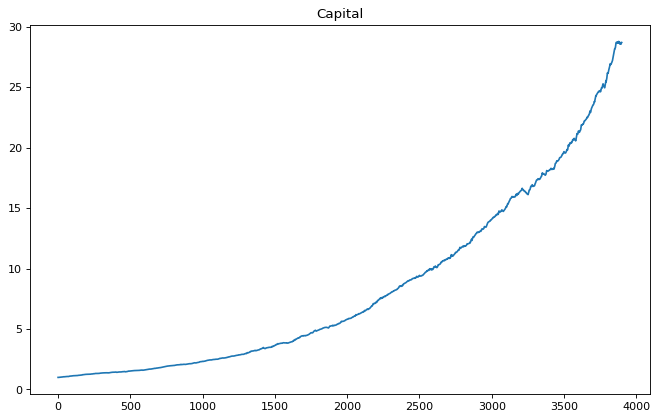

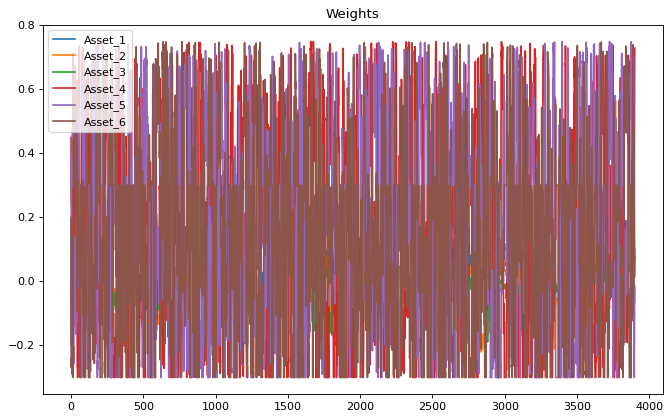

[ 1.          0.9976357   0.99841533 ... 28.65545121 28.66545413
 28.68723789]


In [31]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.optimize import minimize


data = pd.read_csv('Case2.csv')

'''
We recommend that you change your train and test split
'''

TRAIN, TEST = train_test_split(data, test_size = 0.1, shuffle = False)


class Allocator():
    def __init__(self, train_data):
        '''
        Store raw prices and calculate running returns separately
        '''
        self.running_price_paths = train_data.copy()
        #new variable to test returns
        self.daily_returns = train_data.pct_change().dropna().copy()
        self.train_data = train_data.copy()

    def allocate_portfolio(self, asset_prices):
        new_row = pd.DataFrame([asset_prices], columns=self.train_data.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

        # update returns every tick
        if len(self.running_price_paths) >= 2:
            last_return = self.running_price_paths.iloc[-1] / self.running_price_paths.iloc[-2] - 1
            self.daily_returns = pd.concat(
                [self.daily_returns, pd.DataFrame([last_return], columns=self.train_data.columns)],
                ignore_index=True
            )

        if len(self.daily_returns) < 80:
            return np.full(6, 1/6)

        # split assets into two windows since they have different volatilities
        assets_first3 = self.daily_returns.iloc[:, :3]
        assets_last3 = self.daily_returns.iloc[:, 3:]


        # first 3 asset using a simple mean reversion strategy 80 opt
        window = 80
        prices_first3 = self.running_price_paths.iloc[:, :3]
        if len(prices_first3) < window:
            weights_first3 = np.full(3, 1/3)
        else:
            moving_avg = prices_first3.iloc[-window:].mean()
            current = prices_first3.iloc[-1]
            signal = moving_avg - current
            weights_first3 = signal / np.sum(np.abs(signal)) if np.sum(np.abs(signal)) > 0 else np.full(3, 1/3)

        # asset 4,5,6
        recent_returns_last3 = assets_last3.iloc[-5:]
        mu_last3 = recent_returns_last3.mean().values
        cov_last3 = recent_returns_last3.cov().values

        # sharpe def
        def sharpe(w, mu, cov):
            ret = np.dot(w, mu)
            vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            return ret / vol if vol > 0 else 1e6

        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(-1, 1)] * 3

        # last 3 asset markowitz
        w0_last3 = np.full(3, 1/3)
        result_last3 = minimize(
            lambda w: -sharpe(w, mu_last3, cov_last3),
            w0_last3,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 100, 'ftol': 1e-6})

        if result_last3.success:
            weights_last3 = 3*result_last3.x
        else:
            #if optimization fails
            return np.full(6, 1/6)
        #if combine weightss
        combined_weights = np.concatenate([weights_first3, weights_last3])
        total_abs = np.sum(np.abs(combined_weights))
        if total_abs > 0:
            combined_weights = combined_weights / total_abs
        else:
            combined_weights = np.full(6, 1/6)
        return combined_weights

def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0

    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
print(sharpe)
print("Capital shape:", len(capital), "| Test shape:", len(TEST))

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()
print(capital)